In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Data generating model

We generate data from a toy model with one explanatory variable and one response variable.

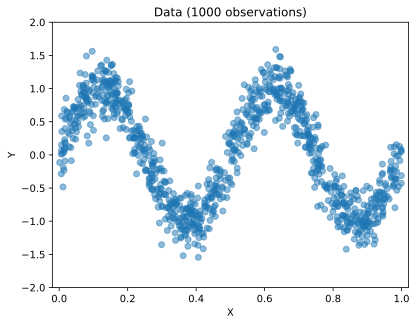

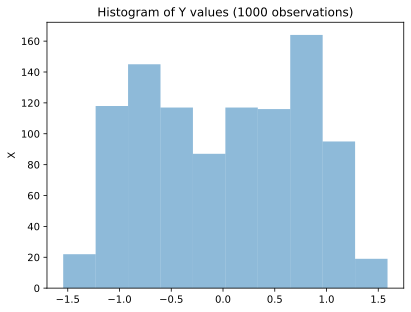

In [2]:
# Set a random seed for reproducibility
np.random.seed(2020)

# Pre-defined model
from mfpi import models
data_model = models.Model_Ex1()

# Sample data
n_data = 1000
X_data, Y_data = data_model.sample(n_data)

# Sample test data
n_test = 1000
X_test, Y_test = data_model.sample(n_test)

# Plot the data
plt.scatter(X_data[:,0], Y_data, alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(-2,2)
plt.xlim(-0.02,1.02)
plt.title("Data ({:d} observations)".format(n_data))
plt.savefig("data.pdf")
plt.show()

# Plot the data
plt.hist(Y_data, alpha=0.5)
plt.ylabel("X")
plt.title("Histogram of Y values ({:d} observations)".format(n_data))
plt.savefig("data_histogram.pdf")
plt.show()

## Warmup: Linear regression

Let's see what happens if we try to apply linear regression to these data.

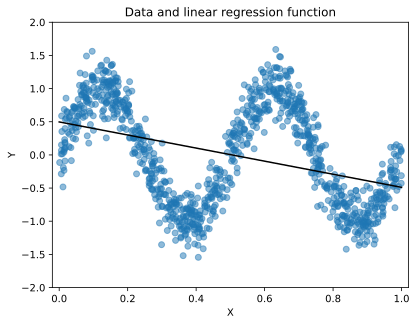

In [3]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Fit a linear model with ordinary least squares
linear_model = sm.OLS(Y_data,sm.add_constant(X_data)).fit()

# Compute the regression function
x_grid = np.linspace(0,1,1000)
X_grid = np.reshape(x_grid, (len(x_grid),1))
f_hat_linear = linear_model.predict(sm.add_constant(X_grid))

# Plot the regression function
plt.scatter(X_data[:,0], Y_data, alpha=0.5)
plt.plot(x_grid, f_hat_linear, color="black")
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(-2,2)
plt.xlim(-0.02,1.02)
plt.title("Data and linear regression function")
plt.show()

We can use linear regression theory to compute prediction intervals, even though the classical assumptions (linearity) are clearly invalid in this case.  

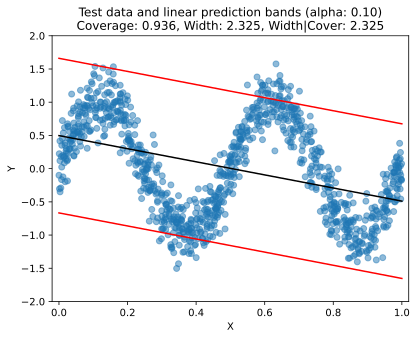

In [4]:
# Nominal significance level (1 - coverage level)
alpha = 0.1

# Compute prediction bands
linear_bands = linear_model.get_prediction(sm.add_constant(X_grid)).summary_frame(alpha=alpha)
linear_bands = np.array(linear_bands)[:,[4,5]]

# Evaluate the empirical coverage
pred_test = linear_model.get_prediction(sm.add_constant(X_test)).summary_frame(alpha=alpha)
lower = np.array(pred_test)[:,4]
upper = np.array(pred_test)[:,5]
covered = (Y_test>=lower) * (Y_test <= upper)
coverage = np.mean(covered)
width = np.mean(upper-lower)
width_cover = np.mean(upper[covered==1]-lower[covered==1])

# Plot the prediction bands and compare them to the test data
plt.scatter(X_test[:,0], Y_test, alpha=0.5)
plt.plot(x_grid, f_hat_linear, color="black")
plt.plot(x_grid, linear_bands[:,0], color="red")
plt.plot(x_grid, linear_bands[:,1], color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(-2,2)
plt.xlim(-0.02,1.02)
txt_subtitle = "Coverage: {:.3f}, Width: {:.3f}, Width|Cover: {:.3f}".format(coverage, width, width_cover)
plt.title("Test data and linear prediction bands (alpha: {:.2f})\n".format(alpha)+txt_subtitle)
plt.show()

## Black-box regression model

We now fit a random forest regression model on the training data.

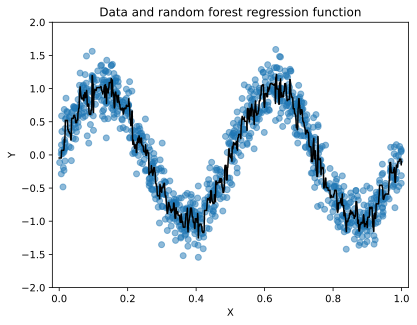

In [5]:
# Fit a random forest to the data
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=10, min_samples_split=10, random_state=2020)
regr.fit(X_data, Y_data)

# Plot the regression function
f_hat = regr.predict(X_grid)
plt.scatter(X_data[:,0], Y_data, alpha=0.5)
plt.plot(x_grid, f_hat, color="black")
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(-2,2)
plt.xlim(-0.02,1.02)
plt.title("Data and random forest regression function")
plt.savefig("data_rf.pdf")
plt.show()

How can we assess the uncertainty of the predictions? Let's look at the residuals.

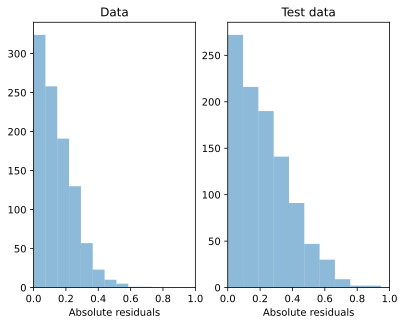

In [6]:
# Compute residuals on data and test data
residuals_data = Y_data - regr.predict(X_data)
residuals_test = Y_test - regr.predict(X_test)

# Plot the absolute residuals
fig, axs = plt.subplots(1, 2, sharex='row')
axs[0].hist(np.abs(residuals_data), alpha=0.5, bins=10)
axs[0].set_xlim(0,1)
axs[0].set_xlabel("Absolute residuals")
axs[0].set_title("Data")
axs[1].hist(np.abs(residuals_test), alpha=0.5, bins=10)
axs[1].set_xlim(0,1)
axs[1].set_xlabel("Absolute residuals")
axs[1].set_title("Test data")
plt.show()

Residuals on the test data tend to be larger than on the train data due to overfitting.

## Split-conformal prediction

Let's construct split-conformal prediction intervals 

In [7]:
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import mquantiles

def split_conformal(X, Y, X_test, black_box, alpha):
    """
    Compute split-conformal prediction bands
    
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : sklearn model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Split the data into training and calibration sets
    X_train, X_calib, Y_train, Y_calib = train_test_split(X, Y, test_size=0.5, random_state=2020)
    
    # Fit the black box model on the training data
    """TODO: write your code here (1 line)"""
    
    # Compute residuals on the calibration data
    """TODO: write your code here (1 line)"""
    
    # Compute suitable empirical quantile of absolute residuals
    """TODO: write your code here (3 lines)"""
    
    # Construct prediction bands
    """TODO: write your code here (3 lines)"""
    
    return lower, upper  

In [8]:
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import mquantiles

def split_conformal(X, Y, X_test, black_box, alpha):
    """
    Compute split-conformal prediction bands
    
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : sklearn model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Split the data into training and calibration sets
    X_train, X_calib, Y_train, Y_calib = train_test_split(X, Y, test_size=0.5, random_state=2020)
    
    # Fit the black box model on the training data
    black_box.fit(X_train, Y_train)
    
    # Compute residuals on the calibration data
    residuals_calib = np.abs(Y_calib - black_box.predict(X_calib))
    
    # Compute suitable empirical quantile of absolute residuals
    n_calib = len(Y_calib)
    level_adjusted = (1.0-alpha)*(1.0+1.0/float(n_calib))
    Q_hat = mquantiles(residuals_calib, prob=level_adjusted)[0]
    
    # Construct prediction bands
    Y_hat = black_box.predict(X_test)
    lower = Y_hat - Q_hat
    upper = Y_hat + Q_hat
    
    return lower, upper 

In [9]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Black box model of choice
black_box = RandomForestRegressor(n_estimators=100, min_samples_split=2, random_state=2020)

# Apply split conformal
lower, upper = split_conformal(X_data, Y_data, X_test, black_box, alpha)

In [10]:
# Evaluate the empirical coverage
covered = (Y_test>=lower) * (Y_test <= upper)
coverage = np.mean(covered)
width = np.mean(upper-lower)
width_cover = np.mean(upper[covered==1]-lower[covered==1])

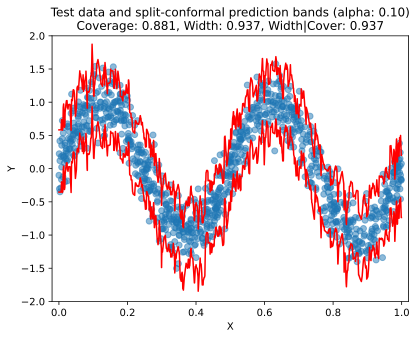

In [11]:
# Plot the prediction bands and compare them to the test data
order = np.argsort(X_test[:,0])
plt.scatter(X_test[order,0], Y_test[order], alpha=0.5)
plt.plot(X_test[order,0], lower[order], color="red")
plt.plot(X_test[order,0], upper[order], color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(-2,2)
plt.xlim(-0.02,1.02)
txt_subtitle = "Coverage: {:.3f}, Width: {:.3f}, Width|Cover: {:.3f}".format(coverage, width, width_cover)
plt.title("Test data and split-conformal prediction bands (alpha: {:.2f})\n".format(alpha)+txt_subtitle)
plt.savefig("test_sc_rf.pdf")
plt.show()

## Heteroscedasticity

We consider now a variation of the previous data generating model which has heteroscedastic noise.

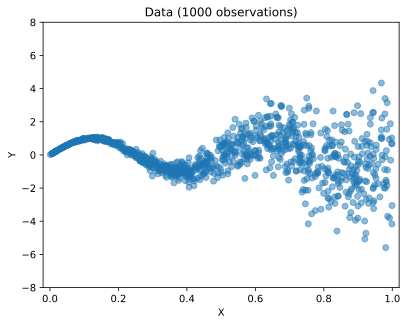

In [12]:
# Set a random seed for reproducibility
np.random.seed(2020)

# Pre-defined model
from mfpi import models
data_model = models.Model_Ex1(a=1)

# Sample data
n_data = 1000
X_data, Y_data = data_model.sample(n_data)

# Sample test data
n_test = 1000
X_test, Y_test = data_model.sample(n_test)

# Plot the data
plt.scatter(X_data[:,0], Y_data, alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(-8,8)
plt.xlim(-0.02,1.02)
plt.title("Data ({:d} observations)".format(n_data))
plt.savefig("data_2.pdf")
plt.show()

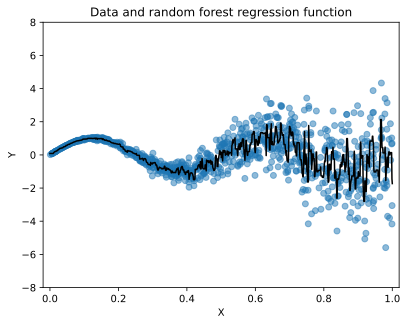

In [13]:
# Fit a random forest to the data
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=10, min_samples_split=10, random_state=2020)
regr.fit(X_data, Y_data)

# Plot the regression function
f_hat = regr.predict(X_grid)
plt.scatter(X_data[:,0], Y_data, alpha=0.5)
plt.plot(x_grid, f_hat, color="black")
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(-8,8)
plt.xlim(-0.02,1.02)
plt.title("Data and random forest regression function")
plt.savefig("data_2_rf.pdf")
plt.show()

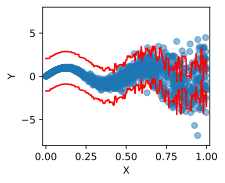

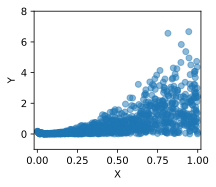

In [14]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Black box model of choice
black_box = RandomForestRegressor(n_estimators=10, min_samples_split=10, random_state=2020)

# Apply split conformal
lower, upper = split_conformal(X_data, Y_data, X_test, black_box, alpha)

# Evaluate the empirical coverage
covered = (Y_test>=lower) * (Y_test <= upper)
coverage = np.mean(covered)
width = np.mean(upper-lower)
width_cover = np.mean(upper[covered==1]-lower[covered==1])

# Compute scores on new data
scores = np.abs(Y_test - black_box.predict(X_test))

# Plot the prediction bands and compare them to the test data
order = np.argsort(X_test[:,0])
plt.figure(figsize=(3,2.5))
plt.scatter(X_test[order,0], Y_test[order], alpha=0.5)
plt.plot(X_test[order,0], lower[order], color="red")
plt.plot(X_test[order,0], upper[order], color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(-8,8)
plt.xlim(-0.02,1.02)
txt_subtitle = "Coverage: {:.3f}, Width: {:.3f}, Width|Cover: {:.3f}".format(coverage, width, width_cover)
#plt.title("Test data and split-conformal prediction bands (alpha: {:.2f})\n".format(alpha)+txt_subtitle)
plt.savefig("test_2_sc_rf.pdf", bbox_inches='tight')
plt.show()


# Plot the scores
plt.figure(figsize=(3,2.5))
plt.scatter(X_test[order,0], scores[order], alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(-1,8)
plt.xlim(-0.02,1.02)
plt.savefig("test_2_sc_rf_scores.pdf", bbox_inches='tight')
plt.show()

## Oracle predictions

Since we know the data generating model, we have access to oracle prediction intervals.

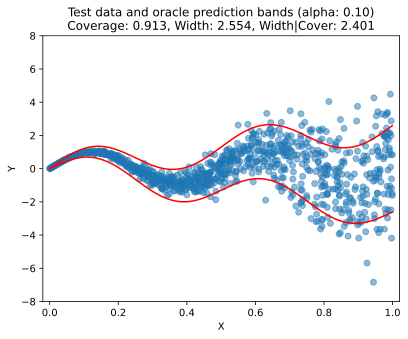

In [15]:
lower, upper = data_model.oracle_predict(X_test, alpha)

# Evaluate the empirical coverage
covered = (Y_test>=lower) * (Y_test <= upper)
coverage = np.mean(covered)
width = np.mean(upper-lower)
width_cover = np.mean(upper[covered==1]-lower[covered==1])

# Plot the prediction bands and compare them to the test data
order = np.argsort(X_test[:,0])
plt.scatter(X_test[order,0], Y_test[order], alpha=0.5)
plt.plot(X_test[order,0], lower[order], color="red")
plt.plot(X_test[order,0], upper[order], color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(-8,8)
plt.xlim(-0.02,1.02)
txt_subtitle = "Coverage: {:.3f}, Width: {:.3f}, Width|Cover: {:.3f}".format(coverage, width, width_cover)
plt.title("Test data and oracle prediction bands (alpha: {:.2f})\n".format(alpha)+txt_subtitle)
plt.savefig("test_2_oracle.pdf")
plt.show()

## Quantile regression

Let's now play fair and forget about the oracle.
We will use a black-box quantile regression model.

In [16]:
from quantile_forest import RandomForestQuantileRegressor

# Fit a quantile regression model
black_box = RandomForestQuantileRegressor(n_estimators=10, min_samples_split=10, random_state=2020)
black_box.fit(X_data, Y_data)

# Estimate conditional quantiles for data set
lower = black_box.predict(X_data, quantiles=alpha/2)
upper = black_box.predict(X_data, quantiles=(1-alpha/2))

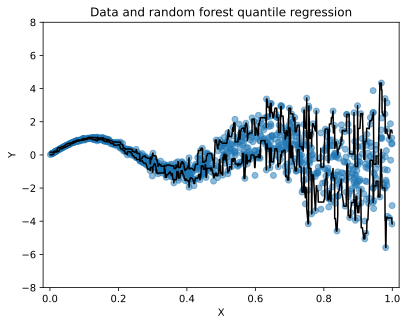

In [17]:
# Plot the QR functions
order = np.argsort(X_data[:,0])
plt.scatter(X_data[order,0], Y_data[order], alpha=0.5)
plt.plot(X_data[order,0], lower[order], color="black")
plt.plot(X_data[order,0], upper[order], color="black")
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(-8,8)
plt.xlim(-0.02,1.02)
plt.title("Data and random forest quantile regression")
plt.savefig("data_2_qr.pdf")
plt.show()

Can we blindly trust the black-box model? Let's see how it does on test data.

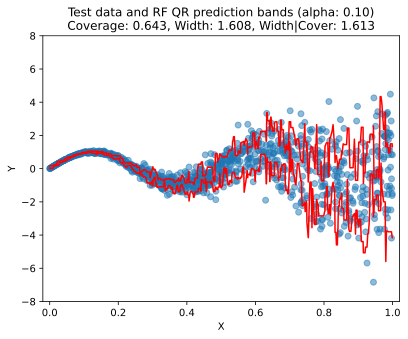

In [18]:
# Estimate conditional quantiles for test data
lower = black_box.predict(X_test, quantiles=alpha/2)
upper = black_box.predict(X_test, quantiles=(1-alpha/2))

# Evaluate the empirical coverage
covered = (Y_test>=lower) * (Y_test <= upper)
coverage = np.mean(covered)
width = np.mean(upper-lower)
width_cover = np.mean(upper[covered==1]-lower[covered==1])

# Plot the prediction bands and compare them to the test data
order = np.argsort(X_test[:,0])
plt.scatter(X_test[order,0], Y_test[order], alpha=0.5)
plt.plot(X_test[order,0], lower[order], color="red")
plt.plot(X_test[order,0], upper[order], color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(-8,8)
plt.xlim(-0.02,1.02)
txt_subtitle = "Coverage: {:.3f}, Width: {:.3f}, Width|Cover: {:.3f}".format(coverage, width, width_cover)
plt.title("Test data and RF QR prediction bands (alpha: {:.2f})\n".format(alpha)+txt_subtitle)
plt.savefig("test_2_qr.pdf")
plt.show()

Maybe we shouldn't trust it.

## Split-conformal quantile regression

Since we don't trust the black-box model, we will use conformal inference.

In [19]:
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import mquantiles
from quantile_forest import RandomForestQuantileRegressor

def cqr(X, Y, X_test, alpha):
    """
    Compute split-conformal quantile regression prediction bands.
    Uses quantile random forests as a black box 
    
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Split the data into training and calibration sets
    """TODO: write your code here (1 line)"""
    
    # Fit a quantile regression model
    """TODO: write your code here (2 lines)"""

    # Estimate conditional quantiles for calibration set
    """TODO: write your code here (2 lines)"""
    
    # Compute conformity scores on the calibration data
    """TODO: write your code here (1 line)"""
    
    # Compute suitable empirical quantile of absolute residuals
    """TODO: write your code here (3 lines)"""
    
    # Construct prediction bands
    """TODO: write your code here (4 lines)"""
    
    return lower, upper 

In [20]:
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import mquantiles
from quantile_forest import RandomForestQuantileRegressor

def cqr(X, Y, X_test, alpha):
    """
    Compute split-conformal quantile regression prediction bands.
    Uses quantile random forests as a black box 
    
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Split the data into training and calibration sets
    X_train, X_calib, Y_train, Y_calib = train_test_split(X, Y, test_size=0.5, random_state=2020)
    
    # Fit a quantile regression model
    black_box = RandomForestQuantileRegressor(n_estimators=10, min_samples_split=10, random_state=2020)
    black_box.fit(X_train, Y_train)

    # Estimate conditional quantiles for calibration set
    lower = black_box.predict(X_calib, quantiles=alpha/2)
    upper = black_box.predict(X_calib, quantiles=(1-alpha/2))
    
    # Compute conformity scores on the calibration data
    residuals_calib = np.maximum(Y_calib - upper, lower - Y_calib)
    
    # Compute suitable empirical quantile of absolute residuals
    n_calib = len(Y_calib)
    level_adjusted = (1.0-alpha)*(1.0+1.0/float(n_calib))
    Q_hat = mquantiles(residuals_calib, prob=level_adjusted)[0]
    
    # Construct prediction bands
    lower = black_box.predict(X_test, quantiles=alpha/2)
    upper = black_box.predict(X_test, quantiles=(1-alpha/2))
    lower = lower - Q_hat
    upper = upper + Q_hat
    
    return lower, upper 

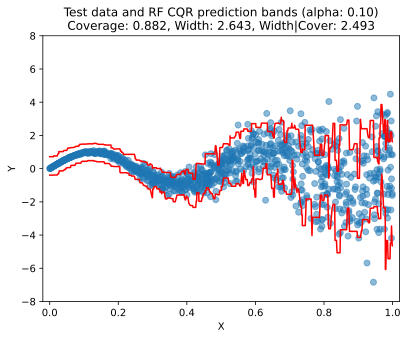

In [21]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Apply quantile regression split conformal
lower, upper = cqr(X_data, Y_data, X_test, alpha)

# Evaluate the empirical coverage
covered = (Y_test>=lower) * (Y_test <= upper)
coverage = np.mean(covered)
width = np.mean(upper-lower)
width_cover = np.mean(upper[covered==1]-lower[covered==1])

# Compute scores on new data
scores = np.maximum(Y_test - upper, lower - Y_test)

# Evaluate the empirical coverage
covered = (Y_test>=lower) * (Y_test <= upper)
coverage = np.mean(covered)
width = np.mean(upper-lower)
width_cover = np.mean(upper[covered==1]-lower[covered==1])

# Plot the prediction bands and compare them to the test data
order = np.argsort(X_test[:,0])
plt.scatter(X_test[order,0], Y_test[order], alpha=0.5)
plt.plot(X_test[order,0], lower[order], color="red")
plt.plot(X_test[order,0], upper[order], color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(-8,8)
plt.xlim(-0.02,1.02)
txt_subtitle = "Coverage: {:.3f}, Width: {:.3f}, Width|Cover: {:.3f}".format(coverage, width, width_cover)
plt.title("Test data and RF CQR prediction bands (alpha: {:.2f})\n".format(alpha)+txt_subtitle)
plt.savefig("test_2_cqr.pdf")
plt.show()